In [1128]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2

%matplotlib inline

### Remove Perspective Skew

In [1311]:
#img_file = '../img/raw/range/IMG_3539.JPG'
#img_file = '../img/raw/range/IMG_3542.JPG'
#img_file = '../img/raw/range/IMG_3544.JPG'
#img_file = '../img/raw/range/IMG_3557.JPG'
#img_file = '../img/raw/range/IMG_3558.JPG'
#img_file = '../img/raw/range/IMG_3559.JPG'

#img_file = '../img/raw/home/IMG_3575.JPG'
img_file = '../img/raw/home/IMG_3585.JPG'
#img_file = '../img/raw/home/IMG_3586.JPG'
#img_file = '../img/raw/home/IMG_3589.JPG'

# TEST SET
#img_file = '../img/raw/test_set/IMG_3590.JPG'
#img_file = '../img/raw/test_set/IMG_3591.JPG'
#img_file = '../img/raw/test_set/IMG_3592.JPG'
#img_file = '../img/raw/test_set/IMG_3593.JPG'
#img_file = '../img/raw/test_set/IMG_3594.JPG'
#img_file = '../img/raw/test_set/IMG_3595.JPG'
#img_file = '../img/raw/test_set/IMG_3596.JPG'
#img_file = '../img/raw/test_set/IMG_3597.JPG'

frame_width = 600
#blue_ratio = (9 + 7/16) / 16.5
blue_ratio = 24 / 42
score_step = frame_width * 2 / 42
width = 600
canny_t1 = 100
canny_t2 = 400
perim_pct = .015

img = cv2.imread(img_file, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
orig = img.copy()

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
height = int(width / img.shape[1] * img.shape[0])
gray = cv2.resize(gray, (width, height))
sigma_val = width // 15
d_val = width // 20

gray = cv2.bilateralFilter(gray, d_val, sigma_val, sigma_val)
edges = cv2.Canny(gray, canny_t1, canny_t2)
kernel = np.ones((4,4), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

_, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
paper = None
max_perim = 0
for c in contours:
    perim = cv2.arcLength(c, True)
    if perim > max_perim:
        approx = cv2.approxPolyDP(c, perim * perim_pct, True)
        if len(approx) == 4:
            paper = approx
            max_perim = perim

#gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
gray = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
if type(paper) != type(None):
    gray = cv2.drawContours(gray, paper, -1, (255, 0, 0), 25)
    
paper = paper.reshape(4, 2)
bounds = paper.copy()
sums = np.sum(paper, axis=1)
diffs = np.diff(paper, axis=1)
bounds[0] = paper[np.argmin(sums)]
bounds[1] = paper[np.argmin(diffs)]
bounds[2] = paper[np.argmax(sums)]
bounds[3] = paper[np.argmax(diffs)]
bounds = (bounds * (img.shape[1] / width)).astype('float32')

top_w = np.linalg.norm(bounds[0] - bounds[1])
btm_w = np.linalg.norm(bounds[2] - bounds[3])
lft_h = np.linalg.norm(bounds[0] - bounds[3])
rgt_h = np.linalg.norm(bounds[1] - bounds[2])
new_w = int(min(top_w, btm_w))
new_h = int(min(lft_h, rgt_h))
new_bounds = np.array([
    [0, 0],
    [new_w, 0],
    [new_w, new_h],
    [0, new_h]
], dtype = 'float32')
M = cv2.getPerspectiveTransform(bounds, new_bounds)
img = cv2.warpPerspective(img, M, (new_w, new_h))

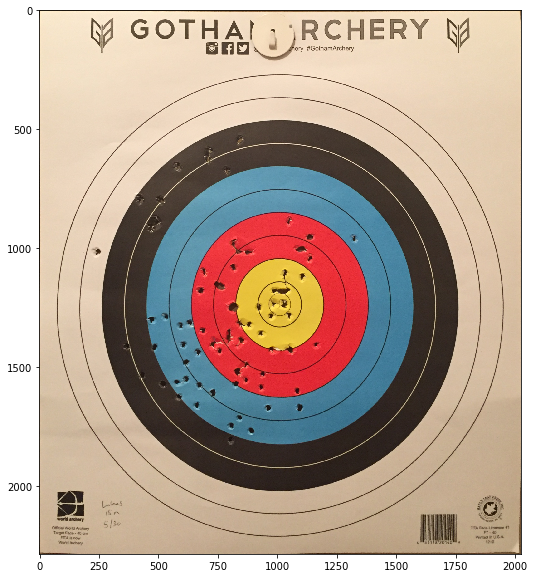

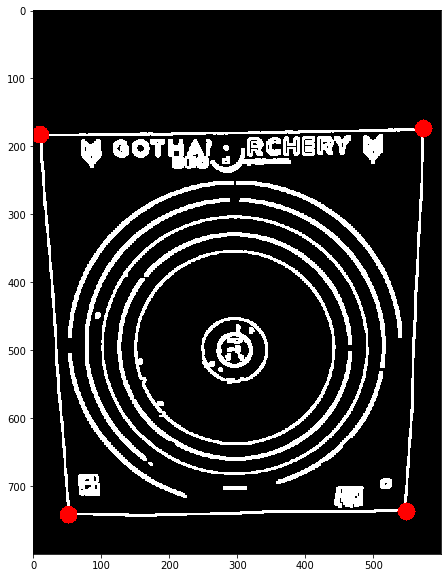

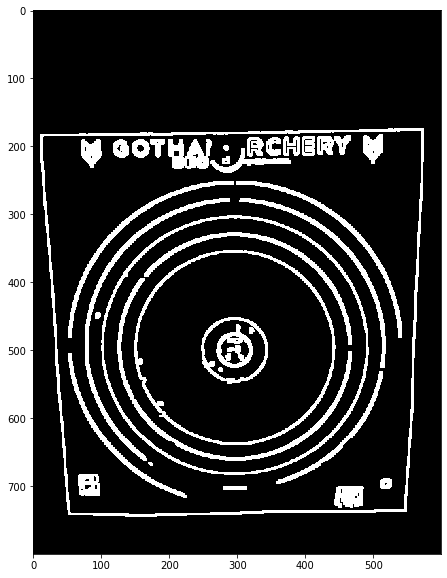

In [1312]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show();

plt.figure(figsize=(10, 10))
plt.imshow(gray)
plt.show();

plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')
plt.show();

In [1313]:
#foo = cv2.cvtColor(gray, cv2.COLOR_RGB2BGR)
#cv2.imwrite('../img/process/process_1_2.jpg', foo)

### Standardize Target Size

In [1314]:
colors = {
    'yellow': [{'low': np.array([15, 130, 130]), 'high': np.array([45, 255, 255])}],
    'red': [{'low': np.array([165, 130, 130]), 'high': np.array([180, 255, 255])},
            {'low': np.array([0, 130, 130]), 'high': np.array([15, 255, 255])}],
    'blue': [{'low': np.array([80, 80, 80]), 'high': np.array([130, 255, 255])}],
}

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
knl_size = (width + height) // 550

circle_data = []
circle_contours = []
for key in colors.keys():
    mask = 0
    for rng in colors[key]:
        mask = cv2.bitwise_or(cv2.inRange(hsv, rng['low'], rng['high']), mask)
    kernel = np.ones((knl_size, knl_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    _, contours, __ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]
    idx = np.argsort(areas)[-1]
    M = cv2.moments(contours[idx])
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    circle_contours.append(contours[idx].copy())
    circle_data.append([areas[idx], center_x, center_y])
    
    '''
    out = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    out = cv2.drawContours(out, contours[idx], -1, (255, 0, 0), 20)
    out = cv2.circle(out, (center_x, center_y), 30, (0, 0, 255), -1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(out)
    plt.show();
    '''
    
circle_data = np.array(circle_data)
target_center = np.mean(circle_data[:, 1:], axis=0).astype(int)

x, y, w, h = cv2.boundingRect(circle_contours[-1])
blue_dim = blue_ratio * frame_width
scl_x = blue_dim / w
scl_y = blue_dim / h
img = cv2.resize(img, None, fx=scl_x, fy=scl_y)

border_size = frame_width // 10
img = cv2.copyMakeBorder(img, *([border_size] * 4), cv2.BORDER_REFLECT)
st_x = int(target_center[0] * scl_x + border_size - frame_width / 2)
st_y = int(target_center[1] * scl_y + border_size - frame_width / 2)
img = img[st_y:st_y+frame_width, st_x:st_x+frame_width]

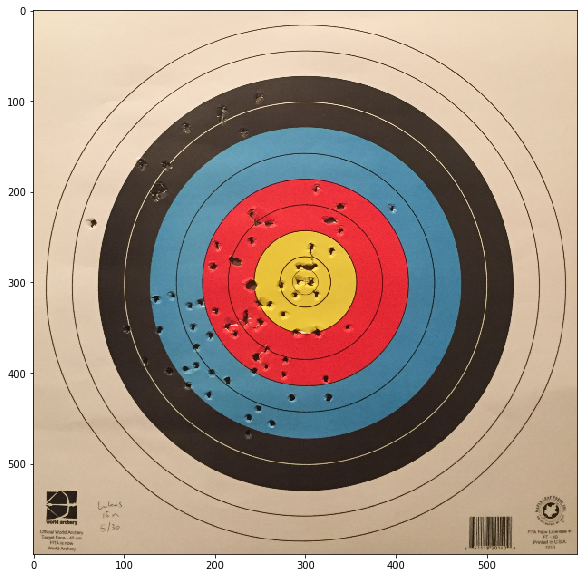

In [1315]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show();

In [1316]:
#foo = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#cv2.imwrite('../img/process/process_1_3.jpg', foo)

### Generate Masks for Each BG Color

In [1318]:
colors = {
    'yellow': [{'low': np.array([15, 130, 130]), 'high': np.array([45, 255, 255])}],
    'red': [{'low': np.array([165, 130, 130]), 'high': np.array([180, 255, 255])},
            {'low': np.array([0, 130, 130]), 'high': np.array([15, 255, 255])}],
    'blue': [{'low': np.array([80, 80, 80]), 'high': np.array([130, 255, 255])}],
    'black': [{'low': np.array([0, 0, 0]), 'high': np.array([180, 255, 130])}],
}
color_steps = {
    'yellow': 2,
    'red': 4,
    'blue': 6,
    'black': 8
}

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
gray = hsv[:, :, 2]

keys = ['red', 'blue', 'black']
circle_masks = []
for key in keys:
    target_area = np.square(color_steps[key] * score_step) * np.pi
    circle = 0
    for rng in colors[key]:
        circle = cv2.bitwise_or(cv2.inRange(hsv, rng['low'], rng['high']), circle)

    _, contours, __ = cv2.findContours(circle, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    idx = np.argmin(np.abs(areas - target_area))
    contour = contours[idx]

    mask = np.zeros_like(gray)
    mask = cv2.fillPoly(mask, pts=[contour], color=255)
    circle_masks.append(mask)
    
circle_masks.append(np.full_like(gray, 255))
for x in range(len(circle_masks)-1, 0, -1):
    circle_masks[x] -= circle_masks[x-1]
    
'''
for mask in circle_masks:
    plt.figure(figsize=(10,10))
    plt.imshow(mask, cmap='gray')
    plt.show();
'''

"\nfor mask in circle_masks:\n    plt.figure(figsize=(10,10))\n    plt.imshow(mask, cmap='gray')\n    plt.show();\n"

### Identify Arrow Holes (Test)

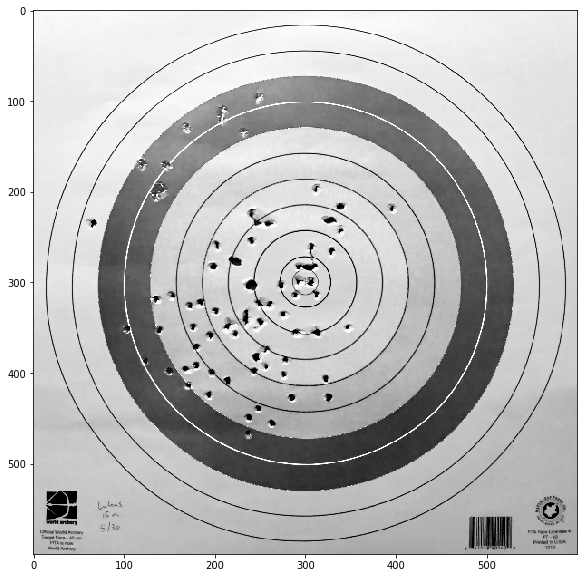

In [1483]:
layers = 0
for mask in circle_masks:
    hist = cv2.calcHist([gray], [0], mask, [32], [0,256])
    pct_max = .01
    max_idx = np.argmax(hist)
    limit = hist[max_idx] * pct_max

    limit_idx = np.argwhere(hist < limit)[:,0]
    try:
        low_val = max(limit_idx[limit_idx < max_idx]) * 8
    except:
        low_val = 0
    try:
        high_val = min(limit_idx[limit_idx > max_idx]) * 8
    except:
        high_val = 255

    layer = gray.copy()
    layer = np.clip(layer, low_val, high_val)
    layer = np.interp(layer, (low_val, high_val), (0, 255)).astype(np.uint8)
    layer = cv2.bitwise_and(layer, layer, mask=mask)
    layers = cv2.add(layers, layer)

layers = cv2.bilateralFilter(layers, 4, 8, 8)

plt.figure(figsize=(10,10))
plt.imshow(layers, cmap='gray')
plt.show();

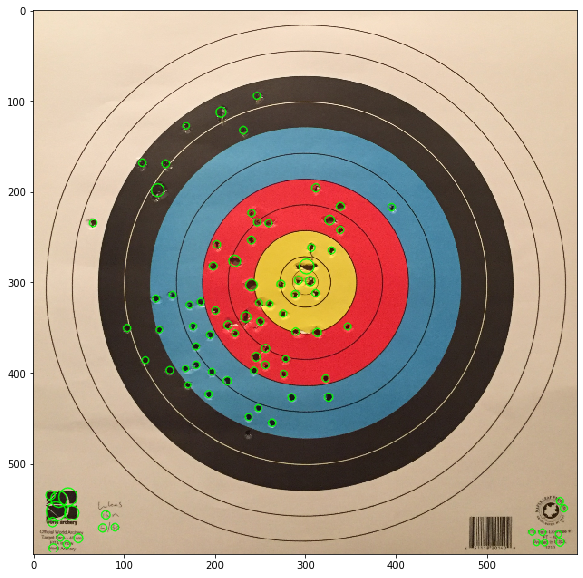

In [1484]:
params = cv2.SimpleBlobDetector_Params()
params.minDistBetweenBlobs = 0
params.filterByArea = True
params.minArea = min_area
params.maxArea = max_area
params.filterByCircularity = True
params.minCircularity = .01
params.filterByConvexity = True
params.minConvexity = .01
params.filterByInertia = True
params.minInertiaRatio = .1

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(layers)

out = cv2.drawKeypoints(img,
                        keypoints,
                        np.array([]),
                        (0,255,0),
                        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 10))
plt.imshow(out)
plt.show();

### Identify Arrow Holes

In [1255]:
min_area = 30
max_area = 600
sigma_val = width // 40
d_val = width // 60

logos = np.array([
    [[5, 525], [55, 600]],
    [[465, 545], [535, 600]],
    [[545, 525], [595, 600]]
])
ref_size = 600
logos = (logos * frame_width / ref_size).astype(int)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:, :, 2]
mask = np.zeros((frame_width, frame_width), dtype=np.uint8)
for logo in logos:
    mask = cv2.rectangle(mask, tuple(logo[0]), tuple(logo[1]), 1, -1)
gray[mask > 0] = np.max(gray)

clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(12,12))
gray = clahe.apply(gray)
gray = cv2.bilateralFilter(gray, d_val, sigma_val, sigma_val)

params = cv2.SimpleBlobDetector_Params()
#params.minThreshold = 10
#params.maxThreshold = 255
#params.thresholdStep = 2
params.minRepeatability = 2
params.minDistBetweenBlobs = 0

params.filterByArea = True
params.minArea = min_area
params.maxArea = max_area
params.filterByCircularity = True
params.minCircularity = .01
params.filterByConvexity = True
params.minConvexity = .01
params.filterByInertia = True
params.minInertiaRatio = .1

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)

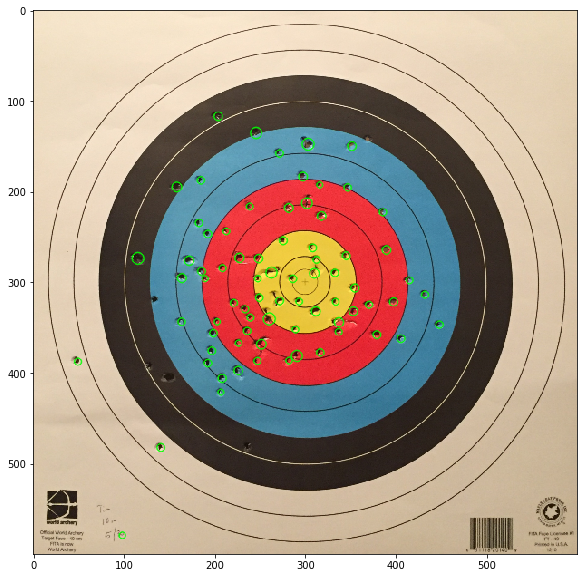

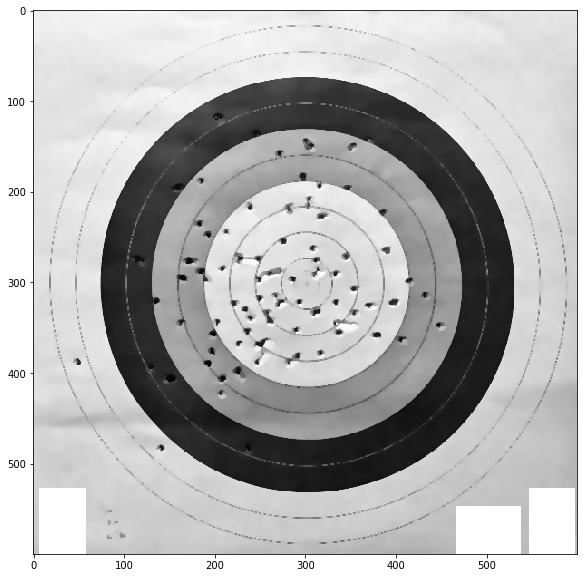

In [1256]:
out = cv2.drawKeypoints(img,
                        keypoints,
                        np.array([]),
                        (0,255,0),
                        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 10))
plt.imshow(out)
plt.show();

plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.show();

foo = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
cv2.imwrite('../img/process/process_1_4.jpg', foo)

### Collect Arrow Hole Coordinates

In [1087]:
pct_smallest = .2
overlap_penalty = .85

arrow_x = []
arrow_y = []
arrow_radii = []
for k in keypoints:
    arrow_x.append(k.pt[0])
    arrow_y.append(k.pt[1])
    arrow_radii.append(k.size / 2)
df = pd.DataFrame({'x':arrow_x, 'y':arrow_y, 'radius':arrow_radii})

num_smallest = np.ceil(len(arrow_radii) * pct_smallest).astype(int)
single_size = np.mean(np.sort(arrow_radii)[:num_smallest]) * overlap_penalty
df['count'] = df['radius'] // single_size
df['count'] = df['count'].replace(0, 1).astype(int)
df['id'] = 0
center = frame_width // 2

if df['count'].max() > 1:
    clus_df = df[df['count'] > 1].copy()
    df = df[~(df['count'] > 1)].copy()
    clus_df = clus_df.loc[clus_df.index.repeat(clus_df['count'])]
    clus_df['id'] = clus_df.groupby(['x', 'y', 'radius', 'count']).cumcount()
    
    clus_df['radius'] /= 2
    clus_df['vec_x'] = center - clus_df['x']
    clus_df['vec_y'] = center - clus_df['y']
    clus_df['mag'] = np.sqrt(np.square(clus_df['vec_x']) +
                                np.square(clus_df['vec_y']))
    clus_df['vec_x'] = clus_df['vec_x'] / clus_df['mag'] * clus_df['radius']
    clus_df['vec_y'] = clus_df['vec_y'] / clus_df['mag'] * clus_df['radius']
    clus_df['rot'] = np.radians(clus_df['id'] / clus_df['count'] * 360)
    
    clus_df['x'] = (clus_df['x'] + np.cos(clus_df['rot']) * clus_df['vec_x'] -
                    np.sin(clus_df['rot']) * clus_df['vec_y'])
    clus_df['y'] = (clus_df['y'] + np.sin(clus_df['rot']) * clus_df['vec_x'] +
                    np.cos(clus_df['rot']) * clus_df['vec_y'])
    df = df.append(clus_df[['x', 'y', 'radius']], sort=False)
    
df.sort_values(['radius', 'id'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(['count', 'id'], axis=1, inplace=True)

df['error'] = np.sqrt(np.square(center - df['x']) + np.square(center - df['y']))
df['score'] = 10 - ((df['error'] - df['radius']) // score_step)
df['score'] = df['score'].clip(0, 10).astype(int)

"\nfor x in range(1, 11):\n    c = plt.Circle((center, center), x * score_step, color='purple', fill=False, lw=1)\n    ax.add_artist(c)\n"

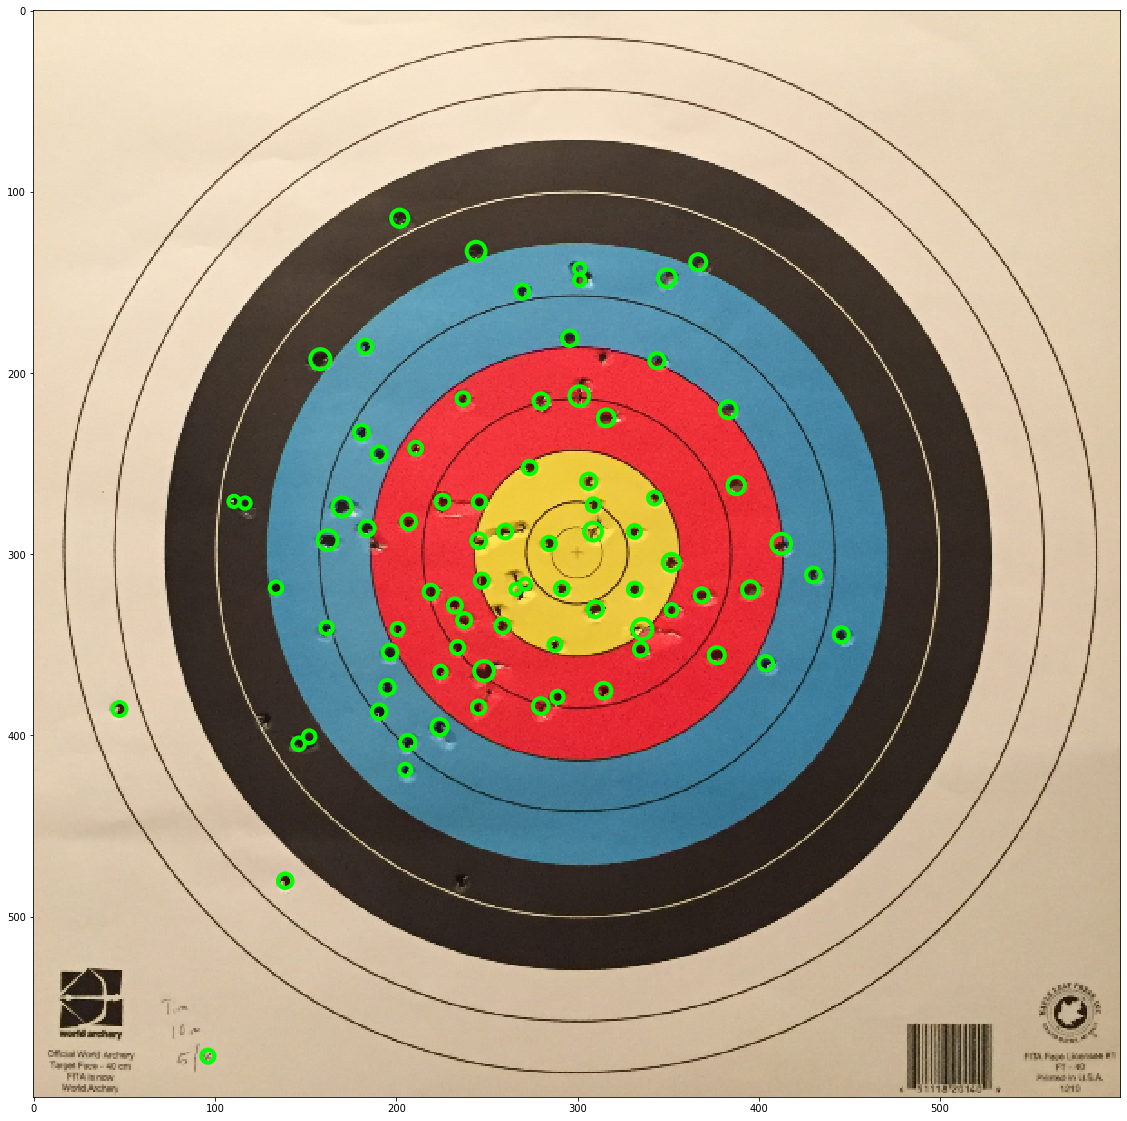

In [1088]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img);
for _, row in df.iterrows():
    c = plt.Circle((row['x'], row['y']), row['radius'], color='lime', fill=False, lw=4)
    ax.add_artist(c)
'''
for x in range(1, 11):
    c = plt.Circle((center, center), x * score_step, color='purple', fill=False, lw=1)
    ax.add_artist(c)
'''
#plt.savefig('../img/process/process_1_5.jpg');
#plt.savefig(img_file.replace('/raw/', '/out/'));

In [1089]:
scores = df['score'].value_counts().sort_index()
indices = scores.index

print('ALL:', sum(scores))
for i,s in zip(indices, scores):
    print(f'{i}:', s)

ALL: 80
0: 1
1: 1
2: 1
3: 1
4: 5
5: 10
6: 12
7: 14
8: 15
9: 15
10: 5
